# PREDICTING HEALTH INSURANCE COSTS USING LINEAR REGRESSION

## Loading the needed libraries/modules

In [35]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score, KFold
from sklearn import model_selection
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,mean_absolute_error

## Loding the Data

In [36]:
# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [37]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '10aMLSSI7Q-HGu8MaCh9X55VFLo_CCHYi' #<-- This is the file id, which i find in almost in the midle of the sharable link. 

download = drive.CreateFile({'id': file_id})


# Downloading the file
download.GetContentFile('insurance.csv')
df  = pd.read_csv("insurance.csv")
df.head()

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    "file_cach

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [38]:
data = df
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


#### I first create a function to distinguish smokers from non-smokers

In [39]:
def identify_smoker(column):
    identified=[]
    
    for row in column:
        
        if row=="yes":
            identified.append(1)
        else:
            identified.append(0)
        
        
    return identified
data["smoker_norm"]=identify_smoker(data["smoker"])

In [40]:
nonnum_cols=[col for col in data.select_dtypes(include=["object"])]

### I also create a function that distinguis obese from non-obese

In [41]:
def identify_obese(column):
    identified=[]
    for row in column:
        if row>30:
            identified.append(1)
        else:
            identified.append(0)
    return identified
data["obese"]=identify_obese(data["bmi"])

In [42]:
data.head(5)

,age,sex,bmi,children,smoker,region,charges,smoker_norm,obese
0,19,female,27.900,0,yes,southwest,16884.92400,1,0
1,18,male,33.770,1,no,southeast,1725.55230,0,1
2,28,male,33.000,3,no,southeast,4449.46200,0,1
3,33,male,22.705,0,no,northwest,21984.47061,0,0
4,32,male,28.880,0,no,northwest,3866.85520,0,0


### Lets now explore what are the relationships between the features and the insurance costs

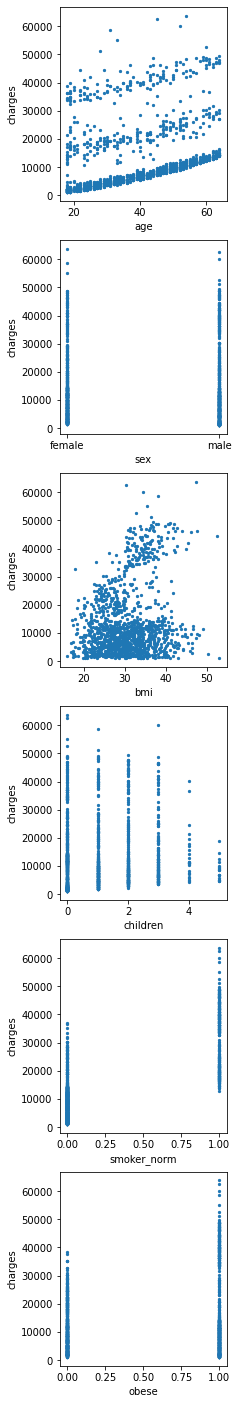

In [48]:
colnum=len(data.columns)-3
fig,ax=plt.subplots(colnum,1,figsize=(3,25))
ax[0].set_ylabel("charges")
p_vals={}
for ind,col in enumerate([i for i in data.columns if i not in ["smoker","region","charges","sex_norm"]]):
    
    ax[ind].scatter(data[col],data.charges,s=5)
    ax[ind].set_xlabel(col)
    ax[ind].set_ylabel("charges")    
plt.show()

age :  0.2990081933306476
bmi :  0.1983409688336288
children :  0.0679982268479048
charges :  1.0
smoker_norm :  0.7872514304984775
obese :  0.19968322199588243


Text(0, 0.5, 'Absolute Correlation')

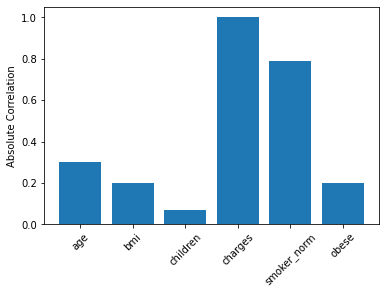

In [49]:
corr_values=[]
collabel=[]
for col in [i for i in data.columns if i not in nonnum_cols]:
    
    p_val=sp.stats.pearsonr(data[col],data["charges"])
    corr_values.append(np.abs(p_val[0]))
    print(col,": ",np.abs(p_val[0]))
    collabel.append(col)
plt.bar(range(1,len(corr_values)+1),corr_values)
plt.xticks(range(1,len(corr_values)+1),collabel,rotation=45)
plt.ylabel("Absolute Correlation")

### It does seems like Smoking, Age and Obesity are the most contributive factors in the calculation of insurance costs, hence, those are the ones I'll use for my predictions.

In [51]:
cols_not_reg = ['age', 'obese', 'smoker_norm']

In [57]:
seed=2
results = []
names = []

def prediction (models):
  for name, model in models:
    kfold = KFold(10, random_state=None)
    cv_results = cross_val_score(model, data[cols_not_reg3], data["charges"], cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, np.mean(cv_results), np.std(cv_results))
    print(msg)

### I will make the predicion using K-fold validation

##### With this cross-validation, I create sets for training and testing, splitting the data into k equally sized portions. I then treat a single portion as a testing set, and what remains is used as training set. I run and test the models in all k portions, averagin the estimates. I'll try with 10 folds using Linear Regression.

In [60]:
kf=KFold(n_splits=10, random_state=1, shuffle=True)
intercepts=[]
mses=[]
coefs=[]

for train_index, test_index in kf.split(data[cols_not_reg]):
    
    lr=linear_model.LinearRegression()
    lr.fit(data[cols_not_reg].iloc[train_index],data["charges"].iloc[train_index])
    lr_predictions=lr.predict(data[cols_not_reg].iloc[test_index])
    
    lr_mse=mean_squared_error(data["charges"].iloc[test_index],lr_predictions)
    
    intercepts.append(lr.intercept_)
    
    coefs.append(lr.coef_)
    mses.append(lr_mse)
    

In [61]:
rmses=[x**.5 for x in mses]
avg_rmse=np.mean(rmses)
avg_intercept=np.mean(intercepts)
age_coefs=[]
obesity_coefs=[]
smoking_coefs=[]
for vals in coefs:
    #print vals[0]
    age_coefs.append(vals[0])
    obesity_coefs.append(vals[1])
    smoking_coefs.append(vals[2])
age_coef=np.mean(age_coefs)
obesity_coef=np.mean(obesity_coefs)
smoking_coef=np.mean(smoking_coefs)
print("a: ",age_coef," b: ",obesity_coef," c: ",smoking_coef," intercept: ",avg_intercept)

a:  261.83801848327676  b:  4227.7376009403615  c:  23851.067053865718  intercept:  -4107.42213325581


### Once i get the coefficients for the Linear Regression, I use a function to automatically predict the insurance costs for a given age, smoking and obesity values.

In [62]:
def estimate_charges(age, obesity, smoking):
  y=(age_coef*age)+(obesity_coef*obesity)+(smoking_coef*smoking)+avg_intercept
  return y

In [70]:
print("The predicted value for a 18 year old obese no smoker is",estimate_charges(18,1,0))
print("The predicted value for a 18 year old obese no smoker is",estimate_charges(25,1,0))
print("The predicted value for a 18 year old obese no smoker is",estimate_charges(35,1,0))
print("The predicted value for a 18 year old obese no smoker is",estimate_charges(55,1,0))
print("The predicted value for a 18 year old obese no smoker is",estimate_charges(65,1,0))
print(" ")

print("The predicted value for a 18 year old obese smoker is",estimate_charges(18,1,1))
print("The predicted value for a 18 year old obese smoker is",estimate_charges(25,1,1))
print("The predicted value for a 18 year old obese smoker is",estimate_charges(35,1,1))
print("The predicted value for a 18 year old obese smoker is",estimate_charges(55,1,1))
print("The predicted value for a 18 year old obese smoker is",estimate_charges(65,1,1))

The predicted value for a 18 year old obese no smoker is 4833.399800383533
The predicted value for a 18 year old obese no smoker is 6666.26592976647
The predicted value for a 18 year old obese no smoker is 9284.646114599238
The predicted value for a 18 year old obese no smoker is 14521.406484264773
The predicted value for a 18 year old obese no smoker is 17139.786669097542
 
The predicted value for a 18 year old obese smoker is 28684.46685424925
The predicted value for a 18 year old obese smoker is 30517.332983632194
The predicted value for a 18 year old obese smoker is 33135.71316846496
The predicted value for a 18 year old obese smoker is 38372.47353813049
The predicted value for a 18 year old obese smoker is 40990.853722963264
